In [1]:
import torch, torchvision
import torch.nn.functional as ff
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
#Configuration & Loading MNIST:
batch_size = 15

transform_src = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])    #zero mean, unit variance

training_set = datasets.MNIST('./data/', train=True, download=True, transform=transform_src)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

testing_set = datasets.MNIST('./data/', train=False, download=True, transform=transform_src)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size, shuffle=True)

In [3]:
#Building the model:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, img):
        x = img.view(-1, 28*28)        #Flatten
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.softmax(self.output(x))
        return x

net_1 = NeuralNetwork()

In [4]:
print(net_1)

NeuralNetwork(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [5]:
#Training moel:
cross_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.0001)
time0 = time()
epochs = 30
training_loss = []

for epoch in range(epochs):
    step_loss = []
    net_1.train()
    running_loss = 0
    for data in training_loader:
        x, y = data
        y_hot = ff.one_hot(y, num_classes=10) 
        optimizer.zero_grad()
        output = net_1(x.view(-1, 28*28))
        loss = cross_loss(output, y_hot.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  
        step_loss.append(loss.item())
    else:
        print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(training_loader)))
        training_loss.append(np.array(step_loss).mean())
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.3032066655158996
Epoch 1 - Training loss: 2.3030842574834822
Epoch 2 - Training loss: 2.30296397703886
Epoch 3 - Training loss: 2.3028454852104185
Epoch 4 - Training loss: 2.30272846442461
Epoch 5 - Training loss: 2.302612655878067
Epoch 6 - Training loss: 2.302497720003128
Epoch 7 - Training loss: 2.3023832800388337
Epoch 8 - Training loss: 2.302268906414509
Epoch 9 - Training loss: 2.302154274880886
Epoch 10 - Training loss: 2.3020390598773957
Epoch 11 - Training loss: 2.3019231011867523
Epoch 12 - Training loss: 2.3018059851527215
Epoch 13 - Training loss: 2.301687477648258
Epoch 14 - Training loss: 2.301567346930504
Epoch 15 - Training loss: 2.301445401132107
Epoch 16 - Training loss: 2.3013214947581293
Epoch 17 - Training loss: 2.3011954210996626
Epoch 18 - Training loss: 2.3010670545697214
Epoch 19 - Training loss: 2.3009364141225817
Epoch 20 - Training loss: 2.3008035426139832
Epoch 21 - Training loss: 2.3006686128377916
Epoch 22 - Training loss: 2.300

In [6]:
#Testing the model:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    time00 = time()
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output, target).item()    #sum up batch loss
            pred = output.argmax(1, keepdim=True)        #get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print("\nTesting Time (in seconds) =",(time()-time00))

In [7]:
test(net_1, testing_loader)


Test set: Accuracy: 1100/10000 (11%)


Testing Time (in seconds) = 5.239056348800659


<function matplotlib.pyplot.show(close=None, block=None)>

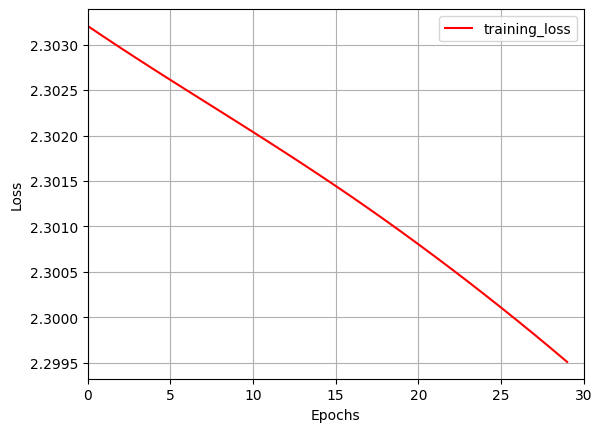

In [9]:
#plotting:
plt.plot(training_loss, label='training_loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 30)
plt.legend()
plt.grid(True)
plt.show